In [1]:
import sys
sys.path.append('../../../..')
sys.path.append('../../../../lib/src/')
import torch
from torch import nn
import os
import numpy as np
from matplotlib import pyplot as plt
import math
import lightning as L
import logging
import torch.nn.functional as F
from sklearn.decomposition import PCA


from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs,Encoder_Chairs_GPVAE, My_Dataset, My_MaskedDataset, make_batched_masks
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.models import LLDM_IAF, LVAE_IAF_Config, LVAE_IAF, GPVAE, GPVAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig, BaseTrainer
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.trainers.training_callbacks import WandbCallback

sys.path.append('diffusion/stable_diffusion/')
sys.path.append('diffusion/stable_diffusion/model/')
from diffusion.stable_diffusion.latent_diffusion import LatentDiffusion, DiffusionWrapper, MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.autoencoder import Autoencoder
from diffusion.stable_diffusion.model.clip_embedder import CLIPTextEmbedder
from diffusion.stable_diffusion.model.unet import UNetModel, _test_time_embeddings
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

from geometric_perspective_on_vaes.sampling import build_metrics, hmc_sampling

def plot_sequence(X):

    if len(X.shape) == 4:
        X = X.unsqueeze(0)

    X = X.cpu().detach().numpy()
    num_seq = X.shape[0]
    num_obs = X.shape[1]

    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)
    plt.figure(figsize=(10, 10))
    for i in range(num_seq):
        for j in range(num_obs):
            plt.subplot(num_seq, num_obs, i*num_obs+j+1)
            plt.imshow(X[i, j].transpose(1, 2, 0))
            plt.axis('off')

    plt.show()
    logger.setLevel(old_level)

def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )

#Defining these important global variables
PROB_MISSING_DATA = 0.1
BATCH_SIZE = 256

    
%reload_ext autoreload
%autoreload 2
!nvidia-smi

Sun Sep  8 20:40:18 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:01:00.0 Off |                  Off |
| 30%   39C    P8             10W /   70W |     119MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# LDM

In [2]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'


data = torch.load(os.path.join('../../my_data/sprites/Sprites_train.pt'))
train_data = data[:-1000, :-1, :, :, :].to(device) #removing the last obs which is the same as the first
eval_data = data[-1000:, :-1, :, :, :].to(device)
test_data = torch.load(os.path.join('../../my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, :-1, :, :, :].to(device)
print(train_data.shape)
train_data = train_data.permute(0, 1, 4, 2, 3)
eval_data = eval_data.permute(0, 1, 4, 2, 3)
test_data = test_data.permute(0, 1, 4, 2, 3)
print(train_data.shape)

if not os.path.exists(f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt'):
    train_seq_mask = make_batched_masks(train_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)
    eval_seq_mask = make_batched_masks(eval_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)
    test_seq_mask = make_batched_masks(test_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)

    torch.save(train_seq_mask, f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    torch.save(eval_seq_mask, f'eval_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    torch.save(test_seq_mask, f'test_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
else:
    print('Loading masks...')
    train_seq_mask = torch.load(f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    eval_seq_mask = torch.load(f'eval_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    test_seq_mask = torch.load(f'test_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')

train_data = train_data[train_seq_mask]
eval_data = eval_data[eval_seq_mask]
test_data = test_data[test_seq_mask]

train_dataset = My_Dataset(train_data)
eval_dataset = My_Dataset(eval_data)
test_dataset = My_Dataset(test_data)

torch.Size([8000, 7, 64, 64, 3])
torch.Size([8000, 7, 3, 64, 64])


In [3]:
input_dim = (3, 64, 64)
f = 32 #subsampling factor
new_num_channels = 3
latent_dim = new_num_channels* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)

training_config = BaseTrainerConfig(output_dir='pre-trained_vae',
num_epochs=100,
learning_rate=1e-3,
per_device_train_batch_size=256,
per_device_eval_batch_size=256,
train_dataloader_num_workers=2,
eval_dataloader_num_workers=2,
steps_saving=25,
optimizer_cls="AdamW",
optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
scheduler_cls="ReduceLROnPlateau",
scheduler_params={"patience": 3, "factor": 0.8})


model_config = VAEConfig(input_dim=input_dim, latent_dim= latent_dim, uses_default_encoder= False, uses_default_decoder= False, reconstruction_loss= 'mse')
encoder = Encoder_Chairs(model_config)
decoder = Decoder_Chairs(model_config)
device = 'cuda'

vae = VAE(model_config=model_config, encoder=encoder, decoder=decoder).to(device)


Latent dim: 12


## First-stage model

In [ ]:
callbacks = [] # the TrainingPipeline expects a list of callbacks
wandb_cb = WandbCallback() # Build the callback 
# SetUp the callback 
wandb_cb.setup(
    training_config=training_config, # pass the training config
    model_config = model_config,
    project_name=f"pre_training_VAE_latdim12_missing_{PROB_MISSING_DATA}", # specify your wandb project # specify your wandb entity
)
callbacks.append(wandb_cb) 

In [ ]:
vae = vae.to('cuda')
pipeline = TrainingPipeline(
    training_config=training_config,
    model=vae
)
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset,
    #callbacks=callbacks
)

In [5]:
vae.load_state_dict(torch.load('pre-trained_vae/VAE_training_2024-09-08_20-41-24/final_model/model.pt')["model_state_dict"])

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


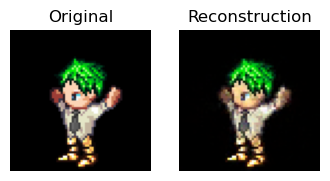

In [8]:
idx = 2556
x = train_dataset[idx]
vae = vae.to('cpu')
out = vae(x)

plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(x.data.cpu().permute(1, 2, 0))
plt.title('Original')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(out['recon_x'].data.cpu().permute(1, 2, 0))
plt.title('Reconstruction')
plt.axis('off')
plt.show()

## LDM per se

In [9]:
# Keeping only last observations

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
data = torch.load(os.path.join('../../my_data/sprites/Sprites_train.pt'))
train_data = data[:-1000, :-1, :, :, :].to(device) #removing the last obs which is the same as the first
eval_data = data[-1000:, :-1, :, :, :].to(device)
test_data = torch.load(os.path.join('../../my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, :-1, :, :, :].to(device)
print(train_data.shape)
train_data = train_data.permute(0, 1, 4, 2, 3)
eval_data = eval_data.permute(0, 1, 4, 2, 3)
test_data = test_data.permute(0, 1, 4, 2, 3)
print(train_data.shape)

if not os.path.exists(f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt'):
    train_seq_mask = make_batched_masks(train_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)
    eval_seq_mask = make_batched_masks(eval_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)
    test_seq_mask = make_batched_masks(test_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)

    torch.save(train_seq_mask, f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    torch.save(eval_seq_mask, f'eval_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    torch.save(test_seq_mask, f'test_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
else:
    print('Loading masks...')
    train_seq_mask = torch.load(f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    eval_seq_mask = torch.load(f'eval_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    test_seq_mask = torch.load(f'test_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')

#Slicing where the last observation is not missing and keeping only the last observation
train_data = train_data[train_seq_mask[:, -1] == 1, -1] 
eval_data = eval_data[eval_seq_mask[:, -1] == 1, -1]
test_data = test_data[test_seq_mask[:, -1] == 1, -1]
print(train_data.shape)

torch.Size([8000, 7, 64, 64, 3])
torch.Size([8000, 7, 3, 64, 64])
Loading masks...
torch.Size([7232, 3, 64, 64])


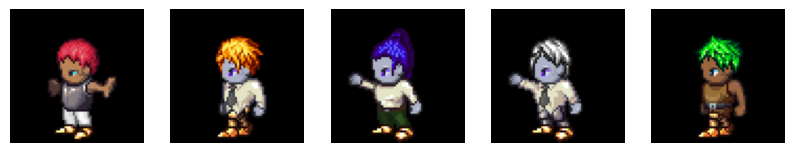

In [10]:
#check
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_data[i].data.cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [13]:
input_dim = (3, 64, 64)
f = 32 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)

device = 'cuda'
vae = VAE.load_from_folder('pre-trained_vae/VAE_training_2024-09-08_20-41-24/final_model').to(device)
vae.eval()

Latent dim: 12


VAE(
  (decoder): Decoder_Chairs(
    (fc): Linear(in_features=12, out_features=2048, bias=True)
    (layers): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (2): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (3): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
  

In [14]:

######## UNET #######
# in_channels = 3
# out_channels = 3
# channels = 64
# n_res_blocks = 2
# attention_levels = [3]
# channel_multipliers = (1, 2, 2, 4)
# n_heads = 2

in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

h, w = 64//f, 64//f


z = torch.randn(1, 3, h, w)
print("Shape of input U-NET: ", z.shape)
empty_prompt_embed = None
print("Shape of output: ", unet(z, torch.tensor([10]), empty_prompt_embed).shape)
print("Number of trainable params: ", sum(p.numel() for p in unet.parameters() if p.requires_grad))

latent_scaling_factor = 1
n_steps = 1000
linear_start =  0.00085
linear_end = 0.0012


latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end)
print("Number of trainable params (should not change): ", sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))

Shape of input U-NET:  torch.Size([1, 3, 2, 2])
Shape of output:  torch.Size([1, 3, 2, 2])
Number of trainable params:  2223043
Number of trainable params (should not change):  2223043


In [ ]:
n_steps = 1000
linear_start =  0.00085
linear_end = 0.012
latent_scaling_factor = 1
lr = 1e-4
BATCH_SIZE = 256
MAX_EPOCHS = 50

vae = vae.to('cuda')
latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end)
model = LitLDM(ldm = latent_diffusion, vae = vae, lr = lr).to('cuda')

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, num_workers = 12)
val_loader = torch.utils.data.DataLoader(eval_data, batch_size=800, num_workers = 12)

trainer = L.Trainer(max_epochs=MAX_EPOCHS,
                     default_root_dir='ldm', accelerator = 'gpu', 
                     check_val_every_n_epoch=5)



trainer.fit(model, train_loader, val_loader)

#model = LitLDM.load_from_checkpoint('ldm/lightning_logs/version_3/checkpoints/epoch=149-step=4800.ckpt', ldm = latent_diffusion, vae = vae, latent_dim = latent_dim).to('cuda')

# LLDM

In [16]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
data = torch.load(os.path.join('../../my_data/sprites/Sprites_train.pt'))
train_data = data[:-1000, :-1, :, :, :].to(device) #removing the last obs which is the same as the first
eval_data = data[-1000:, :-1, :, :, :].to(device)
test_data = torch.load(os.path.join('../../my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, :-1, :, :, :].to(device)
print(train_data.shape)
train_data = train_data.permute(0, 1, 4, 2, 3)
eval_data = eval_data.permute(0, 1, 4, 2, 3)
test_data = test_data.permute(0, 1, 4, 2, 3)
print(train_data.shape)

if not os.path.exists(f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt'):
    train_seq_mask = make_batched_masks(train_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)
    eval_seq_mask = make_batched_masks(eval_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)
    test_seq_mask = make_batched_masks(test_data, PROB_MISSING_DATA, BATCH_SIZE).type(torch.bool)

    torch.save(train_seq_mask, f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    torch.save(eval_seq_mask, f'eval_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    torch.save(test_seq_mask, f'test_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
else:
    print('Loading masks...')
    train_seq_mask = torch.load(f'train_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    eval_seq_mask = torch.load(f'eval_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')
    test_seq_mask = torch.load(f'test_seq_mask-prob_missing_{PROB_MISSING_DATA}.pt')

train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool)
test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)


torch.Size([8000, 7, 64, 64, 3])
torch.Size([8000, 7, 3, 64, 64])
Loading masks...


In [ ]:
PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-09-08_20-41-24/final_model'
PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_0/checkpoints/epoch=49-step=1450.ckpt'

device = 'cuda'
vae = VAE.load_from_folder(PATH_VAE_FOLDER).to(device)
vae.eval()
_, _, _ = vae.retrieveG(train_data, verbose = True, T_multiplier=5, device = device, addStdNorm=True)

in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

latent_scaling_factor = 1
n_steps = 1000

#Pas oublier de modif
linear_start =  0.00085
linear_end = 0.012

input_dim = (3, 64, 64)
f = 32 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)


latent_diffusion = MyLatentDiffusion(unet, latent_scaling_factor, latent_dim, n_steps, linear_start, linear_end)
print('Number of parameters in the diffusion model: ', sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))

model = LitLDM.load_from_checkpoint(PATH_DIFFUSION_CKPT, ldm = latent_diffusion, vae = vae, latent_dim = latent_dim, lr = 6e-4).to(device)
diffusion = model.ldm

In [18]:
model_config = LVAE_IAF_Config(
    input_dim=(3, 64, 64),
    n_obs_per_ind=train_data.shape[1], #8 for Sprites, 7 as we remove last obs
    latent_dim=latent_dim,
    beta=0.3,
    n_hidden_in_made=2,
    n_made_blocks=4,
    warmup=0,
    context_dim=None,
    prior='standard',
    posterior='gaussian',
    linear_scheduling_steps=10,

)


device = 'cuda'
encoder = Encoder_Chairs(model_config).to(device)
decoder = Decoder_Chairs(model_config).to(device)
ddim_sampler = DDIMSampler(diffusion, n_steps = train_data.shape[1]-1, ddim_eta = 1)
temperature = 1


#############
# lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, 
#                 pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
#                 precomputed_zT_samples=zT_samples, GM = GM, verbose = True)
lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler, verbose = True, temp = temperature)
#lvae = LVAE_IAF(model_config, encoder, decoder).cuda()



#lldm.load_state_dict(torch.load('LLDM_IAF_training_0.3.pt'))
#lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-09-07_12-09-45/final_model/model.pt')['model_state_dict'])

Diffusion time steps  [997 831 665 499 333 167   1]
Running on  cuda:0
Freezing pre-trained VAE and pre-trained LDM...
Freezing done.
Number of trainable parameters: 1.1e+06
Number of total parameters: 4.4e+06


In [8]:
lvae = LVAE_IAF(model_config, encoder, decoder).cuda()
lvae.load_state_dict(torch.load('lldm/LVAE_IAF_training_2024-09-06_15-53-04/final_model/model.pt')['model_state_dict'])

<All keys matched successfully>

In [27]:
lldm.beta = 0.2
LR = 6*1e-4
optimizer = torch.optim.Adam(lldm.parameters(), lr=LR)
training_config = BaseTrainerConfig(
        num_epochs=50,
        learning_rate=LR,
        batch_size=BATCH_SIZE,
        steps_saving=50,
        steps_predict=100,
        shuffle=True,
        output_dir='lldm'
    )

### Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True)
trainer = BaseTrainer(
            model=lldm,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            training_config=training_config,
            optimizer=optimizer,
            scheduler=scheduler,
            #callbacks=callbacks
        )
trainer.train()

Model passed sanity check !

Created lldm/LLDM_IAF_training_2024-09-08_21-44-04. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !



Training of epoch 1/50:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss    reg_loss  count
0  104.963721  104.532413    9.0
1   75.992574    0.000000   12.0
2   77.388659    0.000000    7.0
3   70.278796    0.000000   13.0
4   85.167375    0.000000    9.0
5   77.481226    0.000000   11.0
6   70.597277   25.130369    6.0


Eval of epoch 1/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 95.9175
Eval loss: 72.0763
--------------------------------------------------------------------------


Training of epoch 2/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  96.940765  112.375997    3.0
1  70.231606    0.000000    4.0
2  68.899878    0.000000    5.0
3  67.710456    0.000000    6.0
4  70.795549    0.000000    6.0
5  68.140187    0.000000    7.0
6  72.733183   38.662064    5.0


Eval of epoch 2/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 72.5264
Eval loss: 64.8018
--------------------------------------------------------------------------


Training of epoch 3/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  92.054213  115.642746    6.0
1  65.243265    0.000000    6.0
2  67.141441    0.000000    8.0
3  64.093627    0.000000    3.0
4  70.714142    0.000000    3.0
5  63.173759    0.000000    1.0
6  65.436729   22.964369    9.0


Eval of epoch 3/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 72.8834
Eval loss: 70.8604
--------------------------------------------------------------------------


Training of epoch 4/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  96.480703  112.060041    6.0
1  68.362593    0.000000    4.0
2  70.850955    0.000000    5.0
3  68.931820    0.000000    9.0
4  68.745182    0.000000    4.0
5  68.209737    0.000000    3.0
6  69.724083   35.223661    5.0


Eval of epoch 4/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 76.3595
Eval loss: 76.0388
--------------------------------------------------------------------------


Training of epoch 5/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  94.986158  104.757543    7.0
1  67.085574    0.000000    3.0
2  64.003982    0.000000    5.0
3  68.913727    0.000000    1.0
4  72.906694    0.000000    7.0
5  67.343102    0.000000    8.0
6  68.785660   27.433107    5.0


Eval of epoch 5/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 76.0513
Eval loss: 63.7638
--------------------------------------------------------------------------


Training of epoch 6/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  90.609200  104.447330    4.0
1  61.643394    0.000000    4.0
2  63.556513    0.000000    7.0
3  63.350566    0.000000    6.0
4  69.039171    0.000000    6.0
5  63.880135    0.000000    4.0
6  67.684926   24.332259    5.0


Eval of epoch 6/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 70.3709
Eval loss: 64.8372
--------------------------------------------------------------------------


Training of epoch 7/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  91.454204  107.322998    7.0
1  64.204682    0.000000    8.0
2  66.008462    0.000000    5.0
3  63.320984    0.000000    3.0
4  67.539963    0.000000    7.0
5  64.046253    0.000000    3.0
6  69.584529   26.177799    3.0


Eval of epoch 7/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 75.1349
Eval loss: 80.9718
--------------------------------------------------------------------------


Training of epoch 8/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  91.236988  115.415165    4.0
1  65.398350    0.000000    6.0
2  63.412880    0.000000    4.0
3  62.557571    0.000000    6.0
4  68.599583    0.000000    7.0
5  65.126713    0.000000    2.0
6  67.327597   22.752100    7.0


Eval of epoch 8/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 70.2893
Eval loss: 68.3046
--------------------------------------------------------------------------


Training of epoch 9/50:   0%|          | 0/32 [00:00<?, ?batch/s]

     rec_loss   reg_loss  count
0  113.652779  88.049652    1.0
1   73.111746   0.000000    6.0
2   68.486791   0.000000    7.0
3   66.972992   0.000000    4.0
4   70.680300   0.000000    6.0
5   68.291415   0.000000    9.0
6   71.262680  27.338849    3.0


Eval of epoch 9/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 72.1721
Eval loss: 64.8569
--------------------------------------------------------------------------


Training of epoch 10/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  97.452171  105.461033    4.0
1  64.151875    0.000000    6.0
2  63.680954    0.000000    6.0
3  63.840296    0.000000    6.0
4  64.561727    0.000000    7.0
5  64.184545    0.000000    3.0
6  68.963427   18.530748    4.0


Eval of epoch 10/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 71.8735
Eval loss: 63.408
--------------------------------------------------------------------------


Training of epoch 11/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  89.585213  102.318171    4.0
1  59.925978    0.000000    8.0
2  60.315179    0.000000    3.0
3  60.127094    0.000000    5.0
4  63.856367    0.000000    5.0
5  60.261915    0.000000    8.0
6  64.088908   18.695377    3.0


Eval of epoch 11/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 67.2629
Eval loss: 58.8934
--------------------------------------------------------------------------


Training of epoch 12/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  87.202982  101.926582    4.0
1  59.702680    0.000000    5.0
2  59.666673    0.000000    8.0
3  59.210971    0.000000    7.0
4  65.101574    0.000000    2.0
5  59.089137    0.000000    3.0
6  63.072135   13.660784    7.0


Eval of epoch 12/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 67.2876
Eval loss: 60.2733
--------------------------------------------------------------------------


Training of epoch 13/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  85.148722  104.758769    3.0
1  59.790675    0.000000    6.0
2  58.660095    0.000000    3.0
3  60.298674    0.000000    5.0
4  65.459055    0.000000    4.0
5  60.608972    0.000000    9.0
6  62.210416   17.601204    6.0


Eval of epoch 13/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 66.0977
Eval loss: 62.4361
--------------------------------------------------------------------------


Training of epoch 14/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  89.306969  107.436192    2.0
1  58.736543    0.000000    3.0
2  58.442553    0.000000    6.0
3  58.618595    0.000000    8.0
4  67.204847    0.000000    4.0
5  58.656529    0.000000    7.0
6  60.715842   20.434075    6.0


Eval of epoch 14/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.6215
Eval loss: 61.0811
--------------------------------------------------------------------------


Training of epoch 15/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  88.402590  105.920301    4.0
1  59.927468    0.000000    8.0
2  60.544357    0.000000    5.0
3  61.090175    0.000000    5.0
4  62.595673    0.000000    8.0
5  59.796998    0.000000    3.0
6  66.611153   31.014319    3.0


Eval of epoch 15/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 68.1317
Eval loss: 59.5921
--------------------------------------------------------------------------


Training of epoch 16/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  87.158565  107.996498    5.0
1  58.971633    0.000000    7.0
2  58.127958    0.000000    3.0
3  58.501274    0.000000    7.0
4  61.426150    0.000000    5.0
5  58.406779    0.000000    4.0
6  63.110565   16.097916    5.0


Eval of epoch 16/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 67.9539
Eval loss: 60.0996
--------------------------------------------------------------------------


Training of epoch 17/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  84.695480  107.053009    1.0
1  57.879732    0.000000    4.0
2  57.580333    0.000000    7.0
3  56.863371    0.000000    8.0
4  66.059885    0.000000    4.0
5  57.144999    0.000000    3.0
6  59.687760   12.889086    9.0


Eval of epoch 17/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 60.9769
Eval loss: 58.7721
--------------------------------------------------------------------------


Training of epoch 18/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  82.372505  109.519741    4.0
1  57.602213    0.000000    8.0
2  57.846865    0.000000    6.0
3  57.786718    0.000000    5.0
4  62.787846    0.000000    5.0
5  57.486128    0.000000    3.0
6  61.905666   13.910485    5.0


Eval of epoch 18/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 65.2714
Eval loss: 72.6029
--------------------------------------------------------------------------


Training of epoch 19/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  86.434758  108.886212    5.0
1  57.181470    0.000000    5.0
2  57.028027    0.000000    6.0
3  57.169796    0.000000    5.0
4  63.693531    0.000000    3.0
5  56.825277    0.000000    5.0
6  59.480370   10.029580    7.0


Eval of epoch 19/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 64.6932
Eval loss: 57.6509
--------------------------------------------------------------------------


Training of epoch 20/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  85.077454  106.442753    8.0
1  57.193981    0.000000    3.0
2  56.701972    0.000000    3.0
3  57.078654    0.000000    7.0
4  62.724918    0.000000    5.0
5  57.162706    0.000000    5.0
6  60.090520   12.777552    5.0


Eval of epoch 20/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 71.0697
Eval loss: 71.1063
--------------------------------------------------------------------------


Training of epoch 21/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  83.630446  108.462352    5.0
1  58.363281    0.000000    6.0
2  57.195997    0.000000    7.0
3  57.269834    0.000000    7.0
4  62.625983    0.000000    6.0
5  56.299774    0.000000    2.0
6  60.757655   13.813412    3.0


Eval of epoch 21/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 64.7671
Eval loss: 70.7678
--------------------------------------------------------------------------


Training of epoch 22/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  88.307024  104.713684    5.0
1  57.211675    0.000000   11.0
2  58.085381    0.000000    3.0
3  57.785490    0.000000    4.0
4  61.390144    0.000000    5.0
5  57.917727    0.000000    3.0
6  63.163486   13.390440    5.0


Eval of epoch 22/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 65.8693
Eval loss: 61.2651
--------------------------------------------------------------------------


Training of epoch 23/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  85.480713  104.490494    4.0
1  58.029990    0.000000    4.0
2  56.693386    0.000000    7.0
3  57.795414    0.000000    4.0
4  65.879595    0.000000    3.0
5  57.647765    0.000000    8.0
6  59.196110   11.431750    6.0


Eval of epoch 23/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 64.6352
Eval loss: 70.2001
--------------------------------------------------------------------------


Training of epoch 24/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  84.333872  112.081612    4.0
1  56.418460    0.000000    6.0
2  55.847217    0.000000    6.0
3  56.875440    0.000000    4.0
4  64.063739    0.000000    3.0
5  55.630256    0.000000    7.0
6  58.666142    9.925203    6.0


Eval of epoch 24/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 62.2752
Eval loss: 57.0101
--------------------------------------------------------------------------


Training of epoch 25/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  83.374053  109.137070    6.0
1  56.517096    0.000000    4.0
2  56.065648    0.000000    3.0
3  55.560483    0.000000    5.0
4  63.570210    0.000000    4.0
5  55.876715    0.000000    7.0
6  59.141580   11.525287    7.0


Eval of epoch 25/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 67.2119
Eval loss: 57.3318
--------------------------------------------------------------------------


Training of epoch 26/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  84.051048  106.340077    8.0
1  56.771879    0.000000    3.0
2  55.969648    0.000000    7.0
3  55.927322    0.000000    7.0
4  62.376114    0.000000    2.0
5  56.130842    0.000000    6.0
6  58.554019    9.955694    3.0


Eval of epoch 26/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 69.0623
Eval loss: 56.8478
--------------------------------------------------------------------------


Training of epoch 27/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  84.345520  108.316936    4.0
1  55.793098    0.000000    9.0
2  55.541137    0.000000    7.0
3  56.774528    0.000000    5.0
4  61.491469    0.000000    5.0
5  57.774445    0.000000    2.0
6  60.521004   13.269617    4.0


Eval of epoch 27/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.9734
Eval loss: 72.8953
--------------------------------------------------------------------------


Training of epoch 28/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  86.644620  109.184044    3.0
1  56.677331    0.000000    5.0
2  55.771421    0.000000    5.0
3  55.766706    0.000000    4.0
4  62.293078    0.000000    3.0
5  56.058020    0.000000    8.0
6  59.195854   11.325570    8.0


Eval of epoch 28/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 60.8189
Eval loss: 84.4356
--------------------------------------------------------------------------


Training of epoch 29/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  85.629004  108.274319    5.0
1  55.230824    0.000000    2.0
2  55.537824    0.000000    4.0
3  55.805272    0.000000    8.0
4  65.536691    0.000000    3.0
5  55.526727    0.000000    7.0
6  57.824964   10.174159    7.0


Eval of epoch 29/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 61.939
Eval loss: 96.5946
--------------------------------------------------------------------------


Training of epoch 30/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  88.363522  110.689313    5.0
1  55.279411    0.000000    5.0
2  55.322882    0.000000    9.0
3  55.459894    0.000000    7.0
4  62.299149    0.000000    4.0
5  55.960876    0.000000    1.0
6  58.996543   10.518221    5.0


Eval of epoch 30/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 60.6034
Eval loss: 60.1413
--------------------------------------------------------------------------


Training of epoch 31/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  84.853893  111.805894    7.0
1  55.874269    0.000000    7.0
2  55.680151    0.000000    4.0
3  55.683718    0.000000    4.0
4  61.742785    0.000000    6.0
5  55.302291    0.000000    3.0
6  58.085744   11.324747    5.0


Eval of epoch 31/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 68.2698
Eval loss: 55.4834
--------------------------------------------------------------------------


Training of epoch 32/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  85.634657  109.846687    7.0
1  55.532478    0.000000    3.0
2  55.333123    0.000000    6.0
3  55.464388    0.000000    5.0
4  59.674633    0.000000    7.0
5  55.286658    0.000000    5.0
6  60.304129   13.342159    3.0


Eval of epoch 32/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 68.4464
Eval loss: 57.8167
--------------------------------------------------------------------------


Training of epoch 33/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  83.042109  111.681641    4.0
1  56.145966    0.000000    1.0
2  55.314431    0.000000   10.0
3  55.450417    0.000000    5.0
4  59.475372    0.000000    7.0
5  54.862659    0.000000    3.0
6  60.985903   13.942448    6.0


Eval of epoch 33/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.761
Eval loss: 69.2671
--------------------------------------------------------------------------


Training of epoch 34/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  84.129258  110.025500    6.0
1  56.336529    0.000000    4.0
2  55.781458    0.000000    5.0
3  54.855958    0.000000    3.0
4  60.146744    0.000000    9.0
5  56.034384    0.000000    4.0
6  59.339187   11.248061    5.0


Eval of epoch 34/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 65.6863
Eval loss: 59.3605
--------------------------------------------------------------------------


Training of epoch 35/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  77.200211  114.976318    1.0
1  55.209014    0.000000    5.0
2  55.457108    0.000000    6.0
3  55.697365    0.000000    6.0
4  60.739325    0.000000    5.0
5  55.842861    0.000000    6.0
6  59.049840   12.386430    7.0


Eval of epoch 35/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.599
Eval loss: 68.8676
--------------------------------------------------------------------------


Training of epoch 36/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  82.624943  112.302547    4.0
1  56.215555    0.000000    4.0
2  55.617413    0.000000    5.0
3  55.618247    0.000000    7.0
4  61.008263    0.000000    4.0
5  55.801154    0.000000    5.0
6  59.105752   11.165028    7.0


Eval of epoch 36/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 62.1737
Eval loss: 55.2448
--------------------------------------------------------------------------


Training of epoch 37/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  82.519947  110.686956    7.0
1  55.710080    0.000000    7.0
2  55.793723    0.000000    6.0
3  55.093035    0.000000    6.0
4  57.966169    0.000000    6.0
5  55.481529    0.000000    3.0
6  62.804131   12.128961    1.0


Eval of epoch 37/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 67.0745
Eval loss: 68.9657
--------------------------------------------------------------------------


Training of epoch 38/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  84.410933  111.468449    6.0
1  55.493888    0.000000    7.0
2  54.857526    0.000000    5.0
3  55.789417    0.000000    2.0
4  58.692711    0.000000    7.0
5  54.972894    0.000000    4.0
6  60.203358   13.108257    5.0


Eval of epoch 38/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 65.1111
Eval loss: 81.09
--------------------------------------------------------------------------


Training of epoch 39/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  82.344850  111.482785    7.0
1  55.016136    0.000000    6.0
2  55.735655    0.000000    6.0
3  55.401645    0.000000    8.0
4  60.240913    0.000000    1.0
5  55.331080    0.000000    3.0
6  59.536413   11.463752    5.0


Eval of epoch 39/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 64.1011
Eval loss: 58.4519
--------------------------------------------------------------------------


Training of epoch 40/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  83.589336  109.447427    6.0
1  55.233670    0.000000    5.0
2  54.791583    0.000000    4.0
3  54.903382    0.000000    4.0
4  61.164351    0.000000    8.0
5  55.325678    0.000000    5.0
6  57.596970   10.197875    4.0


Eval of epoch 40/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 66.2032
Eval loss: 69.6305
--------------------------------------------------------------------------


Training of epoch 41/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  83.745902  109.180543    6.0
1  55.303876    0.000000    6.0
2  55.121365    0.000000    8.0
3  55.112556    0.000000    4.0
4  60.073096    0.000000    5.0
5  54.736265    0.000000    2.0
6  58.984956   11.458665    5.0


Eval of epoch 41/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 64.5136
Eval loss: 69.7542
--------------------------------------------------------------------------


Training of epoch 42/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  83.303986  111.134415    5.0
1  55.772381    0.000000    3.0
2  55.150813    0.000000    4.0
3  55.206143    0.000000    5.0
4  59.595033    0.000000    7.0
5  55.478488    0.000000    4.0
6  58.203134   11.150208    8.0


Eval of epoch 42/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.5979
Eval loss: 84.6382
--------------------------------------------------------------------------


Training of epoch 43/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  84.618864  111.118971    8.0
1  55.357759    0.000000    7.0
2  54.974866    0.000000    3.0
3        NaN         NaN    0.0
4  59.332460    0.000000    6.0
5  54.654451    0.000000    4.0
6  59.053263   11.193337    8.0


Eval of epoch 43/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 66.6739
Eval loss: 57.6417
--------------------------------------------------------------------------


Training of epoch 44/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  82.697636  109.967584    5.0
1  55.193668    0.000000    6.0
2  55.393830    0.000000    5.0
3  55.007620    0.000000    6.0
4  59.345396    0.000000    5.0
5  55.175996    0.000000    5.0
6  58.375401   11.080783    4.0


Eval of epoch 44/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.9387
Eval loss: 68.9989
--------------------------------------------------------------------------


Training of epoch 45/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  83.113078  109.370218   10.0
1  54.979372    0.000000    5.0
2  54.534643    0.000000    4.0
3  55.119728    0.000000    2.0
4  59.204007    0.000000    6.0
5  55.916486    0.000000    4.0
6  58.576248   11.147889    5.0


Eval of epoch 45/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 70.6272
Eval loss: 54.8539
--------------------------------------------------------------------------


Training of epoch 46/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  85.324277  109.797076    3.0
1  55.207485    0.000000    4.0
2  54.698925    0.000000    7.0
3  55.284583    0.000000    8.0
4  58.916210    0.000000    7.0
5  54.955117    0.000000    4.0
6  59.299898   11.671163    3.0


Eval of epoch 46/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 61.4241
Eval loss: 82.8417
--------------------------------------------------------------------------


Training of epoch 47/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  83.506958  110.806763    4.0
1  55.080388    0.000000    7.0
2  55.428890    0.000000    4.0
3  54.773068    0.000000    7.0
4  59.266009    0.000000    6.0
5  55.050713    0.000000    5.0
6  58.325794   11.624020    3.0


Eval of epoch 47/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 59.2124
Eval loss: 57.5156
--------------------------------------------------------------------------


Training of epoch 48/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  81.397446  111.250698    4.0
1  55.150997    0.000000    3.0
2  54.355582    0.000000    5.0
3  55.208127    0.000000    6.0
4  58.831002    0.000000   10.0
5  55.168697    0.000000    1.0
6  59.189017   11.940148    7.0


Eval of epoch 48/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 63.3602
Eval loss: 69.0776
--------------------------------------------------------------------------


Training of epoch 49/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  82.184397  110.897586    7.0
1  54.860145    0.000000    5.0
2  54.973907    0.000000    2.0
3  54.560661    0.000000    3.0
4  59.450909    0.000000    6.0
5  55.500238    0.000000    7.0
6  58.709726   11.652828    6.0


Eval of epoch 49/50:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 66.0505
Eval loss: 54.9224
--------------------------------------------------------------------------


Training of epoch 50/50:   0%|          | 0/32 [00:00<?, ?batch/s]

    rec_loss    reg_loss  count
0  80.805270  110.752341    6.0
1  55.139267    0.000000    7.0
2  54.645600    0.000000    7.0
3  55.102039    0.000000    2.0
4  59.129186    0.000000    5.0
5  55.658176    0.000000    6.0
6  58.303808   11.630053    3.0


Eval of epoch 50/50:   0%|          | 0/4 [00:00<?, ?batch/s]

Saved checkpoint at epoch 50

--------------------------------------------------------------------------
Train loss: 65.2571
Eval loss: 56.0262
--------------------------------------------------------------------------
Training ended!
Saved final model in lldm/LLDM_IAF_training_2024-09-08_21-44-04/final_model


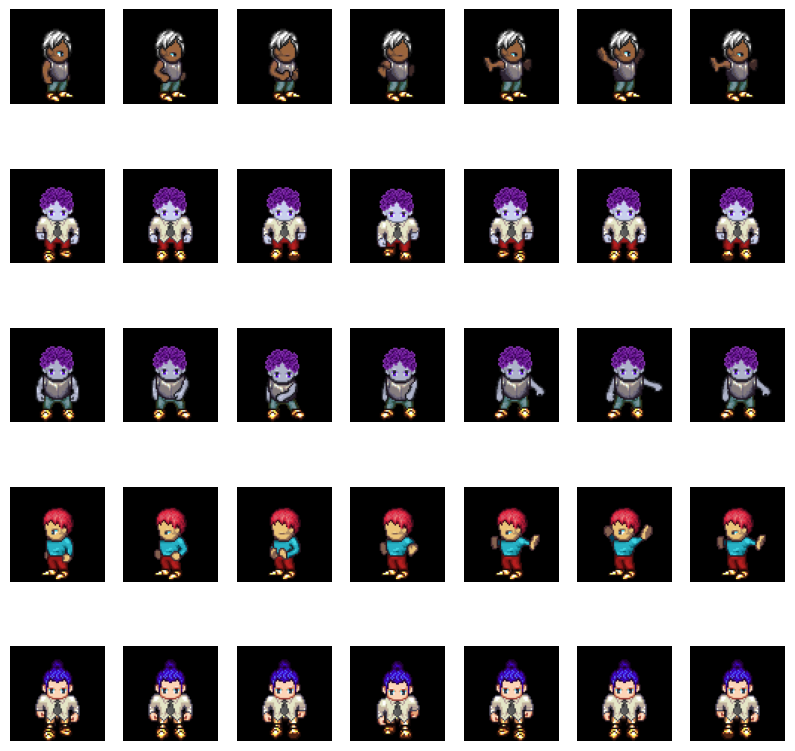

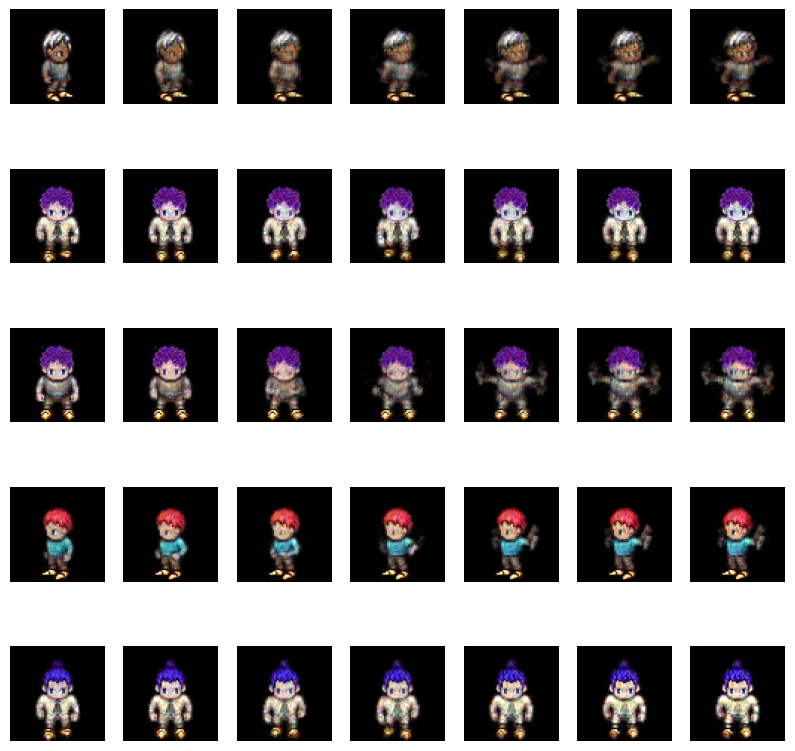

In [29]:
lldm = lldm.to('cpu')
lldm.device = 'cpu'
eval_dataset.data = eval_dataset.data.to('cpu')
_, recon_x = lldm.reconstruct(eval_dataset[5:10], vi_index=0)
plot_sequence(eval_data[5:10])
plot_sequence(recon_x.reshape(5, 7, 3, 64, 64))

In [36]:
train_embeddings = [] 
log_vars = []

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=False)
for i, x in enumerate(train_loader):
    x = x.to('cpu')
    out = lldm.encoder(x)
    z = out.embedding.reshape(-1, 7, 12)
    log_var = out.log_covariance
    train_embeddings.append(z.cpu().detach())
    log_vars.append(log_var.cpu().detach())
train_embeddings = torch.stack(train_embeddings).squeeze(1).reshape(-1, 7, 12)
print(train_embeddings.shape)


torch.Size([8000, 7, 12])


PCA on the whole dataset (56000 data points)


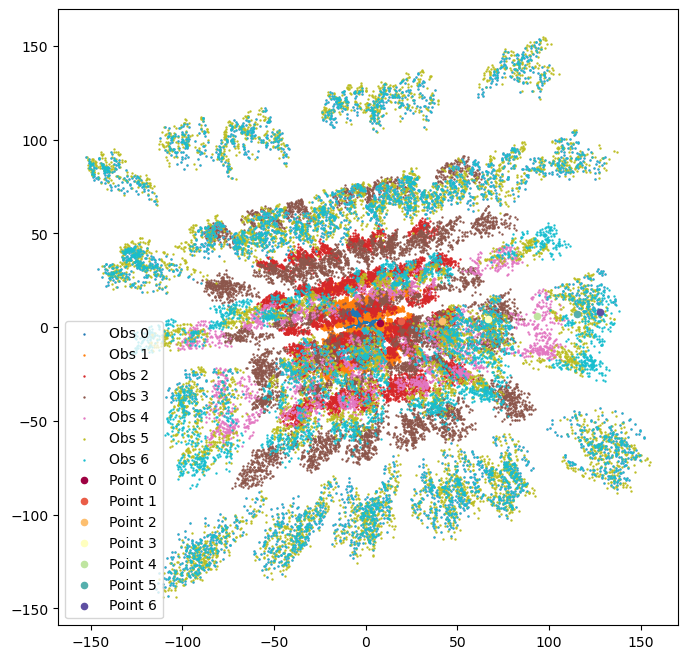

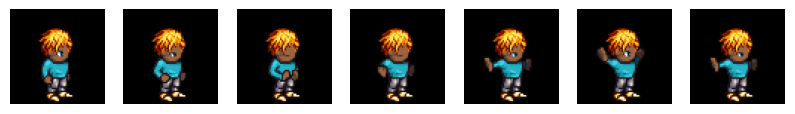

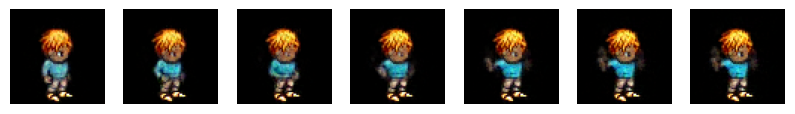

Reconstruction loss: 16.451078414916992


In [37]:
pca = PCA(n_components=2)
num_obs = train_embeddings.shape[1]
lldm = lldm.to('cpu')
#torch.manual_seed(46)

###################
vi_index = 5
projection_index = 'all' # 'all', 'pre
displayed_indexes = range(num_obs)  #range(num_obs)
train_point = 116
lldm.temperature = 1
##################


if projection_index == 'all':
    gathered = train_embeddings.reshape(-1, latent_dim)
    pca.fit(gathered)
    print(f'PCA on the whole dataset ({gathered.shape[0]} data points)')
elif projection_index == 'pre':
    last_preembed = torch.load('preembedding-last.pt')
    #last_preembed = torch.load('pre-embeddings2.pt')
    #last_preembed = torch.load('pre-embeddings-priordecalee.pt')
    pca.fit(last_preembed)
else:
    pca.fit(train_embeddings[:, projection_index, :].reshape(-1, latent_dim))

train_embeddings_pca = []
for i in range(num_obs):
    train_embeddings_pca.append(pca.transform(train_embeddings[:, i, :].reshape(-1, latent_dim)))

train_embeddings_pca = np.stack(train_embeddings_pca).transpose(1, 0, 2)



plt.figure(figsize=(8, 8))
colors = plt.get_cmap('tab10', num_obs)
for i in displayed_indexes:
    plt.scatter(train_embeddings_pca[:, i, 0], train_embeddings_pca[:, i, 1], s=0.5, color=colors(i), label=f'Obs {i}')

x = train_dataset[train_point]

z_seq, x_rec = lldm.reconstruct(x, vi_index = vi_index)

# sampler = lldm.ddim_sampler
# start = train_embeddings[train_point, vi_index, :].cuda().reshape(1, model.c, model.h, model.w)
# _, z_seq, _ = sampler.sample(shape=(1, model.c, model.h, model.w), x_last = start, cond=None)
# z_seq = z_seq[:-1].reshape(-1, latent_dim)
# x_rec = lldm.decoder(z_seq).reconstruction


z_seq_pca = pca.transform(z_seq.cpu().detach())

colors = plt.get_cmap('Spectral', 7)
for i in range(num_obs):
    plt.scatter(z_seq_pca[i, 0], z_seq_pca[i, 1], s=20, color=colors(i), label=f'Point {i}')


plt.legend()
plt.show()

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec)

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss:', recon_loss)


In [38]:
model_config = LVAE_IAF_Config(
    input_dim=(3, 64, 64),
    n_obs_per_ind=train_data.shape[1], #8 for Sprites, 7 as we remove last obs
    latent_dim=latent_dim,
    beta=0.3,
    n_hidden_in_made=2,
    n_made_blocks=4,
    warmup=10,
    context_dim=None,
    prior='standard',
    posterior='gaussian',
    linear_scheduling_steps=10,

)


device = 'cuda'
encoder = Encoder_Chairs(model_config).to(device)
decoder = Decoder_Chairs(model_config).to(device)
lvae = LVAE_IAF(model_config, encoder, decoder).cuda()


LR = 5*1e-4
optimizer = torch.optim.Adam(lvae.parameters(), lr=LR)
training_config = BaseTrainerConfig(
        num_epochs=80,
        learning_rate=LR,
        batch_size=256,
        steps_saving=50,
        steps_predict=100,
        shuffle=True,
        output_dir='lldm'
    )

### Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True)
trainer = BaseTrainer(
            model=lvae,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            training_config=training_config,
            optimizer=optimizer,
            scheduler=scheduler,
            #callbacks=callbacks
        )
trainer.train()

Model passed sanity check !

Created lldm/LVAE_IAF_training_2024-09-08_21-56-12. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !



Training of epoch 1/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 1/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 210.9168
Eval loss: 158.0002
--------------------------------------------------------------------------


Training of epoch 2/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 2/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 142.8033
Eval loss: 135.0196
--------------------------------------------------------------------------


Training of epoch 3/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 3/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.7471
Eval loss: 120.4113
--------------------------------------------------------------------------


Training of epoch 4/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 4/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 112.4583
Eval loss: 105.898
--------------------------------------------------------------------------


Training of epoch 5/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 5/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 100.1701
Eval loss: 95.822
--------------------------------------------------------------------------


Training of epoch 6/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 6/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 91.6113
Eval loss: 88.5665
--------------------------------------------------------------------------


Training of epoch 7/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 7/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 84.8829
Eval loss: 81.5942
--------------------------------------------------------------------------


Training of epoch 8/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 8/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 78.1339
Eval loss: 75.589
--------------------------------------------------------------------------


Training of epoch 9/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 9/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 73.2649
Eval loss: 70.9074
--------------------------------------------------------------------------


Training of epoch 10/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 10/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 83.6811
Eval loss: 70.7361
--------------------------------------------------------------------------


Training of epoch 11/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 11/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 78.2863
Eval loss: 70.4095
--------------------------------------------------------------------------


Training of epoch 12/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 12/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 77.6313
Eval loss: 64.9771
--------------------------------------------------------------------------


Training of epoch 13/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 13/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 68.2238
Eval loss: 63.0136
--------------------------------------------------------------------------


Training of epoch 14/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 14/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 65.8844
Eval loss: 69.1783
--------------------------------------------------------------------------


Training of epoch 15/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 15/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 64.9089
Eval loss: 55.1894
--------------------------------------------------------------------------


Training of epoch 16/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 16/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 61.0348
Eval loss: 51.9618
--------------------------------------------------------------------------


Training of epoch 17/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 17/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.3202
Eval loss: 50.7646
--------------------------------------------------------------------------


Training of epoch 18/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 18/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 56.1254
Eval loss: 48.4288
--------------------------------------------------------------------------


Training of epoch 19/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 19/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.0724
Eval loss: 48.4333
--------------------------------------------------------------------------


Training of epoch 20/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 20/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.162
Eval loss: 46.0174
--------------------------------------------------------------------------


Training of epoch 21/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 21/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 55.2767
Eval loss: 46.1119
--------------------------------------------------------------------------


Training of epoch 22/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 22/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 56.6448
Eval loss: 53.7515
--------------------------------------------------------------------------


Training of epoch 23/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 23/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 58.6477
Eval loss: 61.8312
--------------------------------------------------------------------------


Training of epoch 24/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 24/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.2833
Eval loss: 41.2044
--------------------------------------------------------------------------


Training of epoch 25/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 25/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 53.1799
Eval loss: 46.1564
--------------------------------------------------------------------------


Training of epoch 26/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 26/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.921
Eval loss: 46.3943
--------------------------------------------------------------------------


Training of epoch 27/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 27/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 49.2209
Eval loss: 45.0813
--------------------------------------------------------------------------


Training of epoch 28/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 28/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 51.1124
Eval loss: 45.0134
--------------------------------------------------------------------------


Training of epoch 29/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 29/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.4513
Eval loss: 41.9879
--------------------------------------------------------------------------


Training of epoch 30/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 30/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.1877
Eval loss: 47.8638
--------------------------------------------------------------------------


Training of epoch 31/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 31/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.6173
Eval loss: 35.7913
--------------------------------------------------------------------------


Training of epoch 32/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 32/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.6748
Eval loss: 35.6151
--------------------------------------------------------------------------


Training of epoch 33/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 33/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.7413
Eval loss: 40.2997
--------------------------------------------------------------------------


Training of epoch 34/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 34/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.7167
Eval loss: 40.3327
--------------------------------------------------------------------------


Training of epoch 35/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 35/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.0174
Eval loss: 34.6174
--------------------------------------------------------------------------


Training of epoch 36/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 36/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.0636
Eval loss: 40.5652
--------------------------------------------------------------------------


Training of epoch 37/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 37/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.2352
Eval loss: 51.8528
--------------------------------------------------------------------------


Training of epoch 38/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 38/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 47.0473
Eval loss: 34.3134
--------------------------------------------------------------------------


Training of epoch 39/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 39/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.4242
Eval loss: 39.1194
--------------------------------------------------------------------------


Training of epoch 40/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 40/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.6816
Eval loss: 38.2413
--------------------------------------------------------------------------


Training of epoch 41/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 41/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 43.8567
Eval loss: 33.0728
--------------------------------------------------------------------------


Training of epoch 42/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 42/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.5832
Eval loss: 32.8976
--------------------------------------------------------------------------


Training of epoch 43/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 43/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 44.4245
Eval loss: 40.8184
--------------------------------------------------------------------------


Training of epoch 44/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 44/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.4282
Eval loss: 41.2237
--------------------------------------------------------------------------


Training of epoch 45/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 45/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.6257
Eval loss: 31.8054
--------------------------------------------------------------------------


Training of epoch 46/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 46/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.0993
Eval loss: 31.1649
--------------------------------------------------------------------------


Training of epoch 47/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 47/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.4096
Eval loss: 36.3394
--------------------------------------------------------------------------


Training of epoch 48/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 48/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.2419
Eval loss: 30.9338
--------------------------------------------------------------------------


Training of epoch 49/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 49/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.9277
Eval loss: 37.1699
--------------------------------------------------------------------------


Training of epoch 50/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 50/80:   0%|          | 0/4 [00:00<?, ?batch/s]

Saved checkpoint at epoch 50

--------------------------------------------------------------------------
Train loss: 42.356
Eval loss: 31.3053
--------------------------------------------------------------------------


Training of epoch 51/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 51/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.3477
Eval loss: 30.6769
--------------------------------------------------------------------------


Training of epoch 52/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 52/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.4513
Eval loss: 29.77
--------------------------------------------------------------------------


Training of epoch 53/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 53/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.6648
Eval loss: 29.6549
--------------------------------------------------------------------------


Training of epoch 54/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 54/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.938
Eval loss: 41.6921
--------------------------------------------------------------------------


Training of epoch 55/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 55/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 41.632
Eval loss: 30.0691
--------------------------------------------------------------------------


Training of epoch 56/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 56/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.0584
Eval loss: 35.2454
--------------------------------------------------------------------------


Training of epoch 57/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 57/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.3485
Eval loss: 28.9422
--------------------------------------------------------------------------


Training of epoch 58/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 58/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.701
Eval loss: 33.6266
--------------------------------------------------------------------------


Training of epoch 59/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 59/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.2416
Eval loss: 32.0027
--------------------------------------------------------------------------


Training of epoch 60/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 60/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.3179
Eval loss: 28.2908
--------------------------------------------------------------------------


Training of epoch 61/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 61/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 39.2616
Eval loss: 27.8856
--------------------------------------------------------------------------


Training of epoch 62/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 62/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.8445
Eval loss: 31.8371
--------------------------------------------------------------------------


Training of epoch 63/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 63/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.5849
Eval loss: 32.121
--------------------------------------------------------------------------


Training of epoch 64/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 64/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.1792
Eval loss: 27.6583
--------------------------------------------------------------------------


Training of epoch 65/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 65/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.8828
Eval loss: 32.3349
--------------------------------------------------------------------------


Training of epoch 66/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 66/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.235
Eval loss: 33.7671
--------------------------------------------------------------------------


Training of epoch 67/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 67/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.0502
Eval loss: 27.0199
--------------------------------------------------------------------------


Training of epoch 68/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 68/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.6554
Eval loss: 26.6881
--------------------------------------------------------------------------


Training of epoch 69/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 69/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.3329
Eval loss: 26.4149
--------------------------------------------------------------------------


Training of epoch 70/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 70/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.5724
Eval loss: 26.4997
--------------------------------------------------------------------------


Training of epoch 71/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 71/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 37.3344
Eval loss: 26.3293
--------------------------------------------------------------------------


Training of epoch 72/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 72/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.6779
Eval loss: 33.611
--------------------------------------------------------------------------


Training of epoch 73/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 73/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.8976
Eval loss: 29.4165
--------------------------------------------------------------------------


Training of epoch 74/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 74/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 36.5416
Eval loss: 26.4446
--------------------------------------------------------------------------


Training of epoch 75/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 75/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.9475
Eval loss: 29.348
--------------------------------------------------------------------------


Training of epoch 76/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 76/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 34.7776
Eval loss: 25.1013
--------------------------------------------------------------------------


Training of epoch 77/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 77/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.8036
Eval loss: 25.2589
--------------------------------------------------------------------------


Training of epoch 78/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 78/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.4226
Eval loss: 28.2471
--------------------------------------------------------------------------


Training of epoch 79/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 79/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.2064
Eval loss: 28.2734
--------------------------------------------------------------------------


Training of epoch 80/80:   0%|          | 0/32 [00:00<?, ?batch/s]

Eval of epoch 80/80:   0%|          | 0/4 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 33.3762
Eval loss: 24.8768
--------------------------------------------------------------------------
Training ended!
Saved final model in lldm/LVAE_IAF_training_2024-09-08_21-56-12/final_model


In [ ]:
input_dim = (3, 64, 64)
latent_dim = 12
beta = 1
n_hidden_in_made = 3
n_made_blocks = 2
warmup = 5
context_dim = None
prior = 'standard'
posterior = 'gaussian'
vamp_number_components= 500
linear_scheduling_steps = 10
num_epochs = 150
batch_size = 256
learning_rate=  1e-3 
steps_saving = 50
steps_predict = 100
shuffle_data = True
kernel = "cauchy"
out_channels_time_cnn = 265




config = GPVAEConfig(
    input_dim=input_dim,
    time_length=train_data.shape[1],
    kernel_choice=kernel,
    kernel_scales=1,
    latent_dim=latent_dim,
    sigma=1,
    length_scale=1,
    beta=beta,
    out_channels_time_cnn=out_channels_time_cnn
)

training_config = BaseTrainerConfig(
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        batch_size=batch_size,
        steps_saving=steps_saving,
        steps_predict=steps_predict,
        shuffle=shuffle_data
    )

encoder = Encoder_Chairs_GPVAE(config)
decoder = Decoder_Chairs(config)

#model = LVAE_IAF(config, encoder, decoder).to('cuda')
model = GPVAE(config, encoder, decoder).cuda()

### Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=training_config.learning_rate, eps=1e-4)

### Scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[50, 100, 125, 150],
    gamma=0.5,
    verbose=True
)

trainer = BaseTrainer(
            model=model,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            training_config=training_config,
            optimizer=optimizer,
            scheduler=scheduler,
        )

trainer.train()

In [40]:
model = model.to('cuda')
model.eval()

from tqdm import tqdm
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

mses = []
for i, x in tqdm(enumerate(test_loader)):
    x.data = x.data.to('cuda')
    x.seq_mask = x.seq_mask.to('cuda')
    x.pix_mask = x.pix_mask.to('cuda')
    recon_x = model(x).recon_x.cpu().detach()
    mse = F.mse_loss(recon_x, x.data.cpu().detach(), reduction="none").mean(dim=(1, 2, 3, 4)).detach().cpu()
    mses.append(mse)

mses = torch.cat(mses)
print('MSE:', mses.mean().item())



84it [00:01, 47.38it/s]

MSE: 0.004008693620562553


In [41]:
from tqdm import tqdm
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

rec_losses_lvae, rec_losses_lldm = [], []
lvae = lvae.to('cpu')
lvae.eval()

lldm = lldm.to('cpu')
lldm.device = 'cpu'
lldm.eval()
for i, x in tqdm(enumerate(test_loader)):
    _, x_rec_lvae = lvae.reconstruct(x, vi_index=1, device = 'cpu')
    x_rec_lvae = x_rec_lvae.reshape(-1, 7, 3, 64, 64)
    _, x_rec_lldm = lldm.reconstruct(x, vi_index=2)
    x_rec_lldm = x_rec_lldm.reshape(-1, 7, 3, 64, 64)

    rec_loss_lvae = F.mse_loss(x_rec_lvae.cpu(), x.data, reduction="none").mean(dim=(1, 2, 3, 4)).detach().cpu()
    rec_loss_lldm = F.mse_loss(x_rec_lldm.cpu(), x.data, reduction="none").mean(dim=(1, 2, 3, 4)).detach().cpu()

    rec_losses_lvae.append(rec_loss_lvae)
    rec_losses_lldm.append(rec_loss_lldm)

lvae_loss = torch.cat(rec_losses_lvae).mean().item()
lldm_loss = torch.cat(rec_losses_lldm).mean().item()

print('LVAE loss:', lvae_loss)
print('LLDM loss:', lldm_loss)

0it [00:00, ?it/s]

84it [00:18,  4.47it/s]

LVAE loss: 0.003314302070066333
LLDM loss: 0.0044824834913015366
